In [2]:
#Setting up paths

#Import dill library to save variables generated
import platform
import sys
import dill
import pickle
import path
import os

if platform.system() == "Windows":
    sys.path.append(rf'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Closed_Form_Solver\Code Files')
    sys.path.append(rf'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Closed_Form_Solver\Experimental Results\Tensor_Method\Closed Form')
elif platform.system() == "Darwin":
    sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Code Files')
    
import numpy as np
import pandas as pd
import re
import scipy.io
from sklearn.preprocessing import StandardScaler

#plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

from optimization import inner_product, R2, objective_function_vectorized

# Needed Functions

#conversion of the HCP data from Vector --> Matrix

def vectomat_matlab(vector, outputdim):
    '''
    This code is to regenerate the symmetric functional connectivity matrix from the given vectorized upper triangular portion.
    This code accounts for the mismatch between MATLAB and Python indexing.

    vector: ndarray - the sample vector as a column vector (:,1)
    outputdim: scalar - the dimension of the symmetric matrix
    '''

    # Checking whether the vector dimension and the desired output dimensions match
    vector_length = vector.shape[0]
    desired_length = outputdim * (outputdim - 1) / 2

    # Check if lengths match and raise an error if not
    if vector_length != desired_length:
        raise ValueError("Vector length is insufficient to construct the symmetric matrix.")
    
    # Create a symmetric matrix with zeros
    matrix = np.zeros((outputdim, outputdim))
    
    p = 0
    
    for i in range(outputdim):
        for j in range (i,outputdim):
            if i == j :
                matrix[i,j] = 1
            else:
                matrix[i,j] = vector[p]
                matrix[j,i] = matrix[i,j]
                p = p+1
                
    return matrix

def samplestomat(dataset,outputdim):
    
    '''
    This code is developed to convert the vectorized data matrix in to a 3D data tensor.
    
    dataset : nd:array - (samples*features)
    outputdim : scalar

    '''

    #number of samples
    n_samples = dataset.shape[0]
    #3D matrix to hold the output
    out_dataset = np.zeros((n_samples,outputdim,outputdim))

    for p in range(n_samples):
        
        sample = dataset[p]
        sample = vectomat_matlab(sample,outputdim)
        out_dataset[p] = sample

    random_index = np.random.randint(0, n_samples)
    random_sample = out_dataset[random_index]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(random_sample, cmap='viridis', cbar=True)
    plt.title(f'Heatmap of Random Sample {random_index}')
    plt.show()

    return out_dataset

# normalizing using frobenious norm

def normalize_by_frobenius_norm(samples):
    """
    Normalizes each sample (2D matrix) in the array by its Frobenius norm.

    Parameters:
    samples (numpy.ndarray): A 3D numpy array with dimensions [samples, rows, columns].

    Returns:
    numpy.ndarray: A 3D numpy array with each sample normalized by its Frobenius norm.
    """
    # Calculate the Frobenius norm for each sample
    frobenius_norms = np.linalg.norm(samples, axis=(1, 2))
    
    # Reshape the norms to broadcast correctly for division
    frobenius_norms = frobenius_norms[:, np.newaxis, np.newaxis]
    
    # Normalize each sample by its Frobenius norm
    normalized_samples = samples / frobenius_norms
    
    return normalized_samples


        





### Importing Data

1. For old result files 

In [40]:
#loading file path
if platform.system() == "Windows":
    pkl_file = rf"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression_All_Data\Closed_Form_Solver\LSR\Separation Rank 2\Normalize_Int_Removal\Frobenious\250\HCP_lambdas_[0.1, 0.4, 0.7, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20, 25, 30]_seed_1_sep_2_tucker_[4 4].pkl"
elif platform.system() == "Darwin":
    pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression_All_Data/Closed_Form_Solver/Experimental Results/Tensor_Method/Frobenious_Normalize_Centered/ExecutionTime_intercept_5_2024-07-02 08:34:12, n_train_677,n_test_76, tensor_dimensions:[400 400], tensor_mode_= ranks:[25 25], separation_rank:2, max_iter=50.pkl"

file= open(pkl_file, 'rb')
data = pickle.load(file)
file.close()

# (X_train 0,Y_train 1,X_test 2,Y_test 3, 
# lambda1 4, validation_normalized_estimation_error 5, validation_nmse_losses 6, 
# validation_correlations 7, validation_R2_scores 8, objective_function_information 9,
# gradient_information 10,test_normalized_estimation_error 11, test_nmse_loss 12, test_R2_loss 13, 
# test_correlation 14, objective_function_values 15, gradient_values 16, iterate_level_values 17,
# iterate_level_reconstructed_tensor), file)
X_train_imported = data[0]
Y_train_imported = data[1]
X_test_imported  = data[2]
Y_test_imported  = data[3]
lambda1 = data[4]
validation_normalized_estimation_error = data[5]
validation_nmse_losses = data[6]
validation_correlations = data[7]
validation_R2_scores = data[8]
objective_function_information = data[9]
gradient_information = data[10]
test_normalized_estimation_error = data[11]
test_nmse_loss = data[12]
test_R2_loss = data[13]
test_correlation = data[14]
objective_function_values = data[15]
gradient_values = data[16]
iterate_level_values =  data[17]
iterate_level_reconstructed_tensor = data[18]
#train_error = data[18]
#execution_time = data[19]

In [41]:
print(iterate_level_reconstructed_tensor)

[<LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E97438F4A0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974995820>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974994500>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974994D40>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974996D20>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974994DA0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974996720>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E9749959D0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974994CB0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E9749941D0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974996E40>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974997890>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974997770>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E9749960C0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object at 0x000002E974997AD0>, <LSR_Tensor_2D_v1.LSR_tensor_dot object

2. Importing Data and Preprocessing 

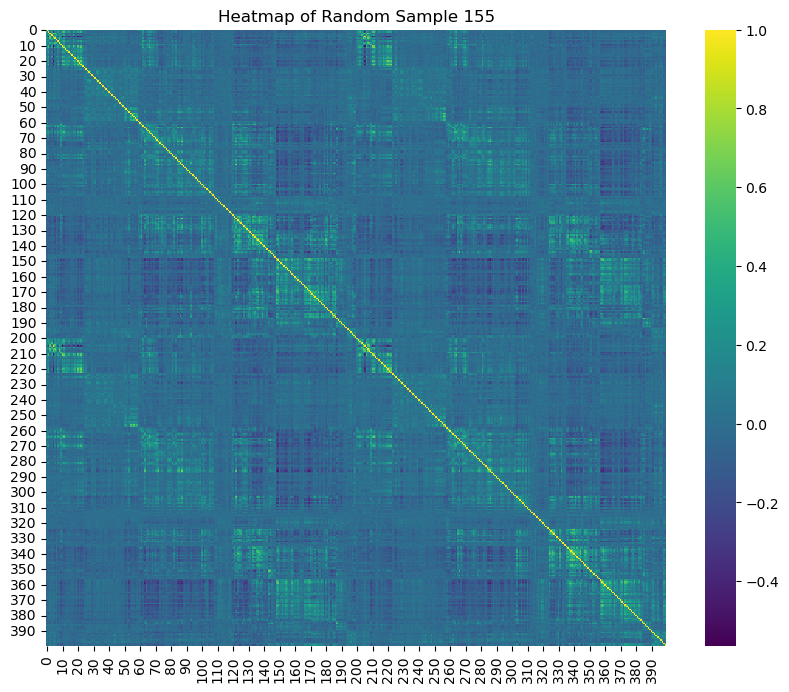

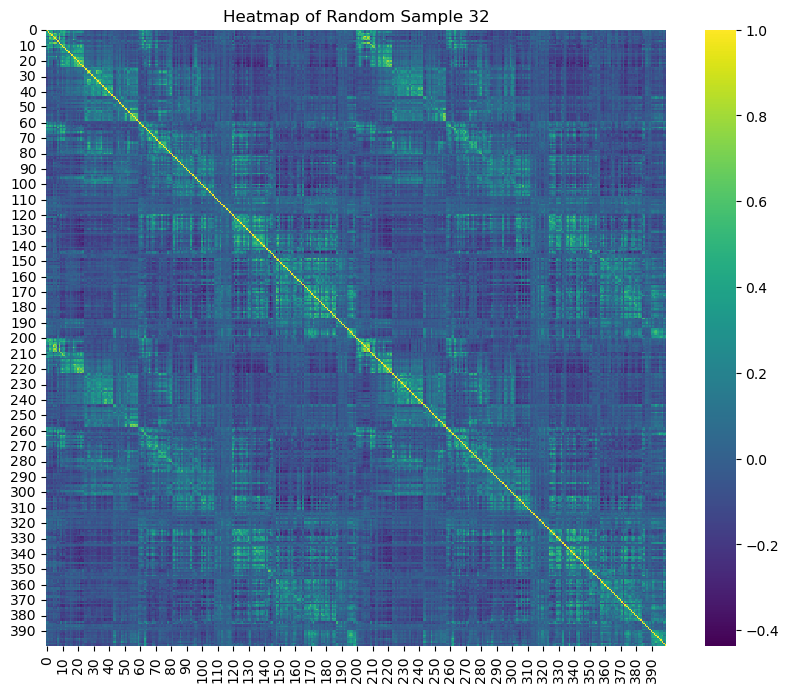

(677, 400, 400)
(677,)
(76, 400, 400)
(76,)
Sample mean for each feature (across samples): [0.01744328 0.00567473 0.00616794 ... 0.00342109 0.00506012 0.01744328]
Sample variance for each feature (across samples): None
Response Average: 1.127096656182391


In [25]:
import platform
import numpy as np

if platform.system() == "Windows": 
    file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\fmri_rs.npy"
elif platform.system() == "Darwin":
    file_path = r"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/fmri_rs.npy"  # Adjust the path for macOS

with open(file_path, "rb") as f:
    fmri_rs = np.load(f)

# Each sample is a row
fmri_rs = fmri_rs.T


# Determine the platform and load the appropriate file
if platform.system() == "Windows": 
    mat_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_60_splits.mat"
elif platform.system() == "Darwin":
    mat_file_path = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_60_splits.mat"
else:
    raise ValueError("Unsupported platform")

# Load the .mat file
mat_file = scipy.io.loadmat(mat_file_path)

# Extract subject lists from the loaded file
seed_1 = mat_file['folds']['seed_1'][0, 0]
subject_lists = seed_1['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0, 0].flatten()]

#Getting the HCP test subjects 

#array to hold the  subjects
HCP_753_Subjects = []
#file path
file_path = ''
#setting the file path
if platform.system() == "Windows":
    file_path = r'D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_753_subs.txt'
elif platform.system() == "Darwin":
    file_path = '/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_753_subs.txt'
#if file pat  h is returned then load
if file_path:
    try:
        with open(file_path, 'r') as file:
            HCP_753_Subjects = [int(line.strip()) for line in file.readlines()]
    except Exception as e:
        print(f"An error occurred: {e}")


#Put the HCP test subjects into a dataframe
# Determine the platform and load the appropriate file
if platform.system() == "Windows":
    csv_file_path = r"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\HCP\Resting State FMRI\MMP_HCP_componentscores.csv"
elif platform.system() == "Darwin":
    csv_file_path = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/HCP/Resting State FMRI/MMP_HCP_componentscores.csv"

df = pd.read_csv(csv_file_path)
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]


#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape labels into column vector
X_train_vec, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test_vec, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))




#Training data
X_train = samplestomat(X_train_vec,400)
X_test  = samplestomat(X_test_vec,400)
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


#Function to row wise normalizati

X_train = normalize_by_frobenius_norm(X_train)
X_test = normalize_by_frobenius_norm(X_test)

#number of samples in train and test 
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)

X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)

# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, X_train.shape[1],X_train.shape[2])
X_test  = X_test_scaled.reshape(n_test, X_test.shape[1],X_train.shape[2])

#average response value
Y_train_mean = np.mean(Y_train)
# Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)






3. Reconstructing the Estimate 

For older versions

In [26]:
# Reconstruction of the Final Matrix 

#Tucker Terms

Matrix = np.zeros(shape = [400,400])

for i in range (len(iterate_level_values)):             
    sep  = iterate_level_values[i][0][-1] @ iterate_level_values[0][2][-1] @ (iterate_level_values[i][1][-1]).T
    Matrix += sep

For Newer Versions

In [27]:
lsr_tensor = iterate_level_reconstructed_tensor[-1]
Matrix = lsr_tensor.expand_to_tensor()

print(f'is symmetric before {np.array_equal(Matrix, Matrix.T)}')



AttributeError: 'list' object has no attribute 'expand_to_tensor'

### Bias Variance Trade off

1. Training Error

In [28]:

Y_train_predicted = inner_product(np.transpose(X_train, (0, 2, 1)), Matrix.flatten(order ='F')) 

train_nmse_loss = np.sum(np.square((Y_train_predicted.flatten() - Y_train.flatten()))) / np.sum(np.square(Y_train.flatten()))    
train_R2_loss = R2(Y_train.flatten(), Y_train_predicted.flatten())
train_correlation = np.corrcoef(Y_train_predicted.flatten(), Y_train.flatten())[0, 1]

print('Training Error Matrices')
print(f'NMSE: {train_nmse_loss} CORR: {train_correlation} R2: {train_R2_loss}')

Training Error Matrices
NMSE: 0.5248355341431239 CORR: 0.7379514989744912 R2: 0.4751644658568761


2. Testing Error 

In [29]:
Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), Matrix.flatten(order ='F')) + Y_train_mean

test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))    
test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

print('Testing Error Matrices')
print(f'NMSE:{test_nmse_loss} CORR:{test_correlation} R2: {test_R2_loss}')

Testing Error Matrices
NMSE:0.762507838586085 CORR:0.47367240356627766 R2: 0.1825420780221768


### Imposing Symmetry

1. Making the parameter matrix symmetric

In [30]:
#Projecting on to the space of symmeteric matirces 
sym_param = (Matrix + Matrix.T)/2

print(sym_param.shape)
print(f'Is symmetric {sym_param == sym_param.T}')

(400, 400)
Is symmetric [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


2. Testing 

In [31]:
X_test = X_test
Y_test = Y_test

from optimization import inner_product, R2, objective_function_vectorized

Y_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), sym_param.flatten(order ='F')) + Y_train_mean

nmse_loss = np.sum(np.square((Y_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
R2_loss = R2(Y_test.flatten(), Y_predicted.flatten())
correlation = np.corrcoef(Y_predicted.flatten(), Y_test.flatten())[0, 1]

print(f'NMSE: {test_nmse_loss} NMSE_sym: {nmse_loss}')
print(f'Correlation: {test_correlation} CORR_sym: {correlation}')
print(f'R2: {test_R2_loss} R2_sym: {R2_loss}')

NMSE: 0.762507838586085 NMSE_sym: 0.762507838586085
Correlation: 0.47367240356627766 CORR_sym: 0.47367240356627766
R2: 0.1825420780221768 R2_sym: 0.1825420780221768


3. Results are the same let's look at the heat map.

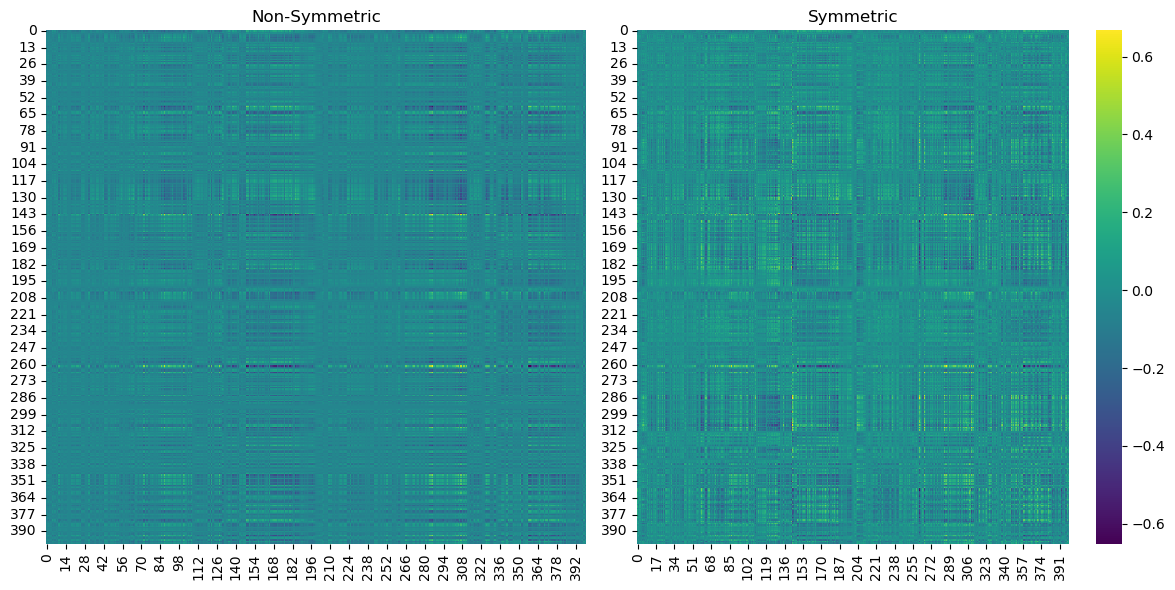

In [32]:

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(Matrix, ax=ax1, cmap="viridis", cbar=False)
ax1.set_title("Non-Symmetric")

# Plot the second heatmap
sns.heatmap(sym_param, ax=ax2, cmap="viridis")
ax2.set_title("Symmetric")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [93]:
print(f'is symmetric before {np.array_equal(Matrix, Matrix.T)}')
print(f'is symmetric after {np.array_equal(sym_param, sym_param.T)}')

distance = np.linalg.norm(Matrix - Matrix.T,ord = 'fro')

print(distance)

is symmetric before False
is symmetric after True
60.83168861494401
(400, 25)
